# 2. PyTorch Neural Network Classification

Em problemas de classificação, o objetivo é prever a categoria à qual uma instância pertence. Duas variações comuns são **multi-class** e **multi-label**.

| Tipo de Problema             | Definição | Exemplo |
|------------------------------|-----------|---------|
| **Binary Classification**    | O alvo pode ser uma de duas opções (sim/não). | Prever se alguém tem ou não uma doença cardíaca. |
| **Multi-Class Classification** | O alvo pode ser uma entre várias opções (mais de duas), mas apenas uma por instância. | Identificar se uma imagem contém comida, uma pessoa ou um cachorro. |
| **Multi-Label Classification** | O alvo pode pertencer a múltiplas categorias ao mesmo tempo. | Atribuir múltiplas categorias a um artigo da Wikipedia (ex: "Matemática", "Ciência" e "Filosofia"). |

### Diferença principal:
- **Multi-Class:** Cada instância pertence a **apenas uma** classe.
- **Multi-Label:** Cada instância pode pertencer a **múltiplas** classes simultaneamente.



In [12]:
import sys 
!{sys.executable} -m pip install scikit-learn pandas matplotlib

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split


## Dados Iniciais

In [ ]:
n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42) # noise torna o conjunto mais disperso

In [6]:
print(f"X features:\n{X[:5]}")
print(f"\ny labels:\n{y[:5]}")

X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

y labels:
[1 1 1 1 0]


In [10]:
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [11]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

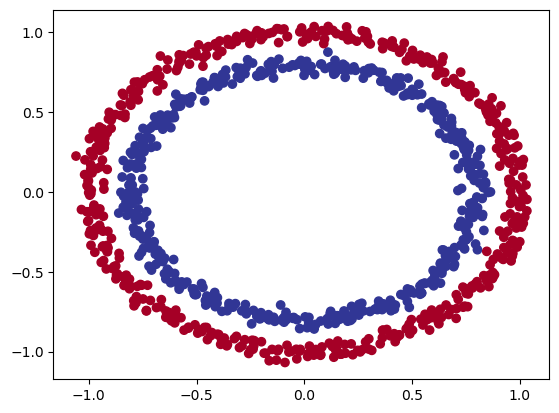

In [14]:
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

In [15]:
X.shape, y.shape

((1000, 2), (1000,))

In [17]:
X = torch.from_numpy(X).type(torch.float) # transforma em tensor
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## Modelo

In [20]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
class CircleModelV0(nn.Module):

    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=5) # se usarmos apenas 2 features, a rede pode não ter capacidade suficiente para aprender padrões complexos, por isso expande para 5
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # passa pelos layers em sequência, primeiro na 1 e depois na 2

In [23]:
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [24]:
untrained_preds = model_0(X_test.to(device))

print(f"Length Preds: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length Test Samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length Preds: 200, Shape: torch.Size([200, 1])
Length Test Samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.5555],
        [0.5102],
        [0.4609],
        [0.5832],
        [0.1223],
        [0.0973],
        [0.2382],
        [0.1407],
        [0.4753],
        [0.5035]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [31]:
loss_fn = nn.BCEWithLogitsLoss() # usado para problemas de classificação binarias (sigmoide + BCE -> BCE mede o erro)

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [25]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # compara se dois tensores sao iguais elemento a elemento e retorna um bool indicando quais sao iguais
    # ao fim retorna quantos são iguais
    acc = (correct / len(y_pred)) * 100 # calcula porcentagem de acertos
    return acc

## Treinar Modelo

### **Etapas do Treinamento em PyTorch**   

1️. **Forward Pass** – O modelo processa os dados de entrada e faz previsões.  

2️. **Cálculo da Perda** – Compara as previsões do modelo com os valores reais para medir o erro.  

3️. **Zerar os Gradientes** – Reseta os gradientes acumulados para evitar interferências na próxima atualização.  

4️. **Backpropagation** – Calcula os gradientes dos parâmetros do modelo em relação à perda.  

5️. **Atualização dos Parâmetros** – Ajusta os pesos do modelo para minimizar a perda usando descida do gradiente.  

Esse ciclo se repete por várias épocas até que o modelo aprenda a fazer melhores previsões

In [26]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.5555],
        [0.5102],
        [0.4609],
        [0.5832],
        [0.1223]], grad_fn=<SliceBackward0>)

A saída bruta do modelo não são probabilidades então para interpretar esses logits é melhor aplicar a sigmoid

In [27]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6354],
        [0.6249],
        [0.6132],
        [0.6418],
        [0.5305]], grad_fn=<SigmoidBackward0>)

In [ ]:
# arredonda para 0 ou 1
y_preds = torch.round(y_pred_probs)

# faz o mesmo so que pras saidas brutas
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# verificação igualdade (probabilidades e saidas brutas)
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# remove dimensão extra
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)

In [29]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [ ]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # Modo de treinamento
    model_0.train()

    # 1. Forward pass 
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # transforma em 0 ou 1
  
    # 2. Loss/accuracy
    loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss funciona com logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Modo de validação
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)


    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71200, Accuracy: 50.00% | Test loss: 0.71249, Test acc: 50.00%
Epoch: 10 | Loss: 0.70173, Accuracy: 56.25% | Test loss: 0.70283, Test acc: 55.00%
Epoch: 20 | Loss: 0.69781, Accuracy: 51.88% | Test loss: 0.69910, Test acc: 54.50%
Epoch: 30 | Loss: 0.69609, Accuracy: 51.38% | Test loss: 0.69748, Test acc: 53.00%
Epoch: 40 | Loss: 0.69518, Accuracy: 51.12% | Test loss: 0.69666, Test acc: 53.00%
Epoch: 50 | Loss: 0.69462, Accuracy: 50.88% | Test loss: 0.69618, Test acc: 52.00%
Epoch: 60 | Loss: 0.69424, Accuracy: 51.00% | Test loss: 0.69587, Test acc: 51.00%
Epoch: 70 | Loss: 0.69395, Accuracy: 50.75% | Test loss: 0.69565, Test acc: 50.50%
Epoch: 80 | Loss: 0.69374, Accuracy: 50.75% | Test loss: 0.69548, Test acc: 49.50%
Epoch: 90 | Loss: 0.69357, Accuracy: 50.62% | Test loss: 0.69536, Test acc: 49.00%


## Previsões e Validações 

In [33]:
import requests
from pathlib import Path 

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

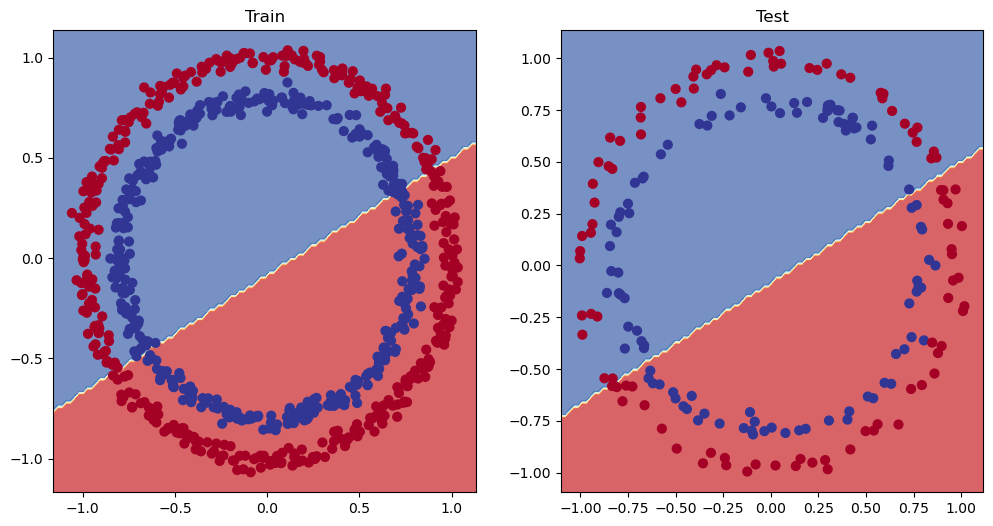

In [34]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

#### O gráfico mostra Underfitting

#### Melhorando o modelo (do ponto de vista do modelo)

| Técnica de melhoria do modelo        | O que ela faz                                                                                                          |
|--------------------------------------|------------------------------------------------------------------------------------------------------------------------|
| **Adicionar mais camadas**           | Cada camada pode aumentar as capacidades de aprendizado do modelo, sendo capaz de aprender novos padrões nos dados. Camadas adicionais são frequentemente chamadas de deixar a rede neural mais "profunda". |
| **Adicionar mais unidades ocultas**  | Semelhante ao acima, mais unidades ocultas por camada significa um aumento potencial nas capacidades de aprendizado do modelo. Mais unidades ocultas são frequentemente chamadas de deixar a rede neural mais "larga". |
| **Treinar por mais tempo (mais épocas)** | O modelo pode aprender mais se tiver mais oportunidades de olhar os dados.                                                                 |
| **Alterar as funções de ativação**   | Alguns dados não podem ser ajustados apenas com linhas retas (como vimos), usar funções de ativação não lineares pode ajudar nisso (dica, dica). |
| **Alterar a taxa de aprendizado**   | Menos específico do modelo, mas ainda relacionado, a taxa de aprendizado do otimizador decide o quanto o modelo deve mudar seus parâmetros a cada passo. Se for muito alta, o modelo pode corrigir em excesso, se for muito baixa, o modelo pode não aprender o suficiente. |
| **Alterar a função de perda**        | Também menos específico do modelo, mas ainda importante, diferentes problemas requerem diferentes funções de perda. Por exemplo, uma função de perda de entropia cruzada binária não funcionará em um problema de classificação multi-classe. |
| **Usar aprendizado por transferência** | Pegue um modelo pré-treinado de um domínio de problema semelhante ao seu e ajuste-o para o seu próprio problema. O aprendizado por transferência será coberto no notebook 06. |

Essas são algumas maneiras de melhorar o desempenho do modelo ajustando sua estrutura ou seu processo de treinamento.

In [39]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # layer extra
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # função ativação que ajuda a rede neural a aprender relações não lineares
        
    def forward(self, x): 
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [40]:
loss_fn = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [44]:
torch.manual_seed(42)

epochs = 2400

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # Modo de treinamento
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) 

    # 2. Loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Modo de validação
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.00300, Accuracy: 100.00% | Test loss: 0.01273, Test acc: 99.50%
Epoch: 100 | Loss: 0.00298, Accuracy: 100.00% | Test loss: 0.01269, Test acc: 99.50%
Epoch: 200 | Loss: 0.00295, Accuracy: 100.00% | Test loss: 0.01265, Test acc: 99.50%
Epoch: 300 | Loss: 0.00292, Accuracy: 100.00% | Test loss: 0.01262, Test acc: 99.50%
Epoch: 400 | Loss: 0.00289, Accuracy: 100.00% | Test loss: 0.01258, Test acc: 99.50%
Epoch: 500 | Loss: 0.00286, Accuracy: 100.00% | Test loss: 0.01254, Test acc: 99.50%
Epoch: 600 | Loss: 0.00284, Accuracy: 100.00% | Test loss: 0.01251, Test acc: 99.50%
Epoch: 700 | Loss: 0.00281, Accuracy: 100.00% | Test loss: 0.01248, Test acc: 99.50%
Epoch: 800 | Loss: 0.00278, Accuracy: 100.00% | Test loss: 0.01244, Test acc: 99.50%
Epoch: 900 | Loss: 0.00276, Accuracy: 100.00% | Test loss: 0.01241, Test acc: 99.50%
Epoch: 1000 | Loss: 0.00273, Accuracy: 100.00% | Test loss: 0.01237, Test acc: 99.50%
Epoch: 1100 | Loss: 0.00271, Accuracy: 100.00% | Test loss: 0.0123

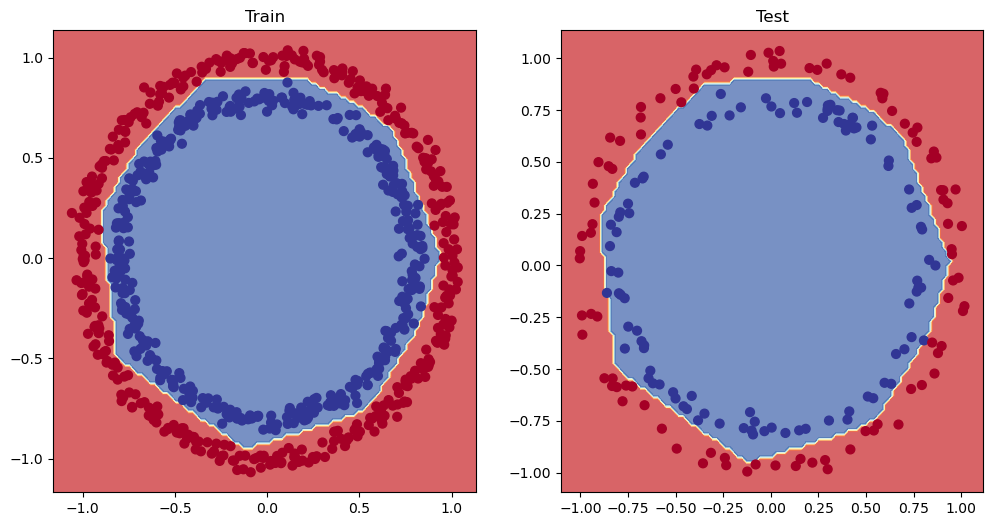

In [45]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)